<a href="https://colab.research.google.com/github/mattmason36/pyTorch-testing/blob/main/CNN_externalImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [7]:
# Convert MNIST image files into tensor of 4 dimensions (# of images, height,
# width, color channel)
transform = transforms.ToTensor()

In [8]:
# train data
train_data = datasets.MNIST(root='/cnn_data', train = True, download = True, transform = transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 335kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.18MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.54MB/s]


In [9]:
# Test Data
test_data = datasets.MNIST(root='/cnn_data', train = False, download = True, transform = transform)

In [10]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [11]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [12]:
# Create a small batch size for images....lets say 10
train_loader = DataLoader(train_data, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle = False)

In [13]:
# Define our CNN Model
# Decribe convolutional layer and what it`s doing (2 convolutional layers)
# This is just an example in the next video we`ll build out the actual model
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [14]:
# Grab one MNIST record
for i, (X_Train, y_train) in enumerate(train_data):
    break

In [15]:
X_Train.shape

torch.Size([1, 28, 28])

In [16]:
x = X_Train.view(1, 1, 28, 28)

In [17]:
# Perform our first convolution
x = F.relu(conv1(x)) # Recrified Linear Unit for our activation function

In [18]:
# 1 single image, 6 is the filters we asked for, 26x26
x.shape

torch.Size([1, 6, 26, 26])

In [19]:
# pass thru the pooling layer
x= F.max_pool2d(x, 2, 2) # kernel of 2 and stride of 2

In [20]:
x.shape # 26/2 = 13

torch.Size([1, 6, 13, 13])

In [21]:
# Do our second convolutional layer
x = F.relu(conv2(x))

In [22]:
x.shape # Agaion we didnt set padding so we loose the 2 pixels of the outline of the image

torch.Size([1, 16, 11, 11])

In [23]:
# Pooling layer
x = F.max_pool2d(x, 2, 2)

In [24]:
x.shape # 11/2 = 5.5 we have to round down, because we can't invent data to round up

torch.Size([1, 16, 5, 5])

In [25]:
((28-2)/2-2)/2

5.5

In [26]:
# Model class
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        # Fully connected
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2) # 2x2 kernel and stride 2
        # Second pass
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2) # 2x2 kernel and stride 2
        # Flatten
        X = X.view(-1, 16*5*5) # Negative one ss that we can vary the batch size

        # Fully connected layers
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim = 1)

In [27]:
# Create an instance of our model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [28]:
# Loss function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # Smaller the learning rate the longer its gonna take to train

In [29]:
import time
start_time = time.time()

# Create vaialbles to track tings
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loop of Epochs
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0


    # Train
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1 # start our batches at 1
        y_pred = model(X_train) # get predicted values from the training set. Not flattened
        loss = criterion(y_pred, y_train) # how off are we? Compare the predictions to correct answers in y_train

        predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions. Indexed off the first point
        batch_corr = (predicted == y_train).sum() # how many we got correct from this batch. True = 1, False = 0, sum those up
        trn_corr += batch_corr # keep track as we go along in training

        # Update our parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        # print out some results
        if b % 600 == 0:
            print(f'epoch: {i} batch: {b} loss: {loss.item()}')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Test

    with torch.no_grad(): # No gradients so we dont update our weights and biases with data
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1] # Add up correct predictions
            tst_corr += (predicted == y_test).sum() # T=1, F=0 and sum away

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)


current_time = time.time()
total = current_time - start_time
print(f'Training took: {total/60} minutes!')

epoch: 0 batch: 600 loss: 0.1623610556125641
epoch: 0 batch: 1200 loss: 0.1502392590045929
epoch: 0 batch: 1800 loss: 0.4744560718536377
epoch: 0 batch: 2400 loss: 0.14238706231117249
epoch: 0 batch: 3000 loss: 0.007758188061416149
epoch: 0 batch: 3600 loss: 0.3836284875869751
epoch: 0 batch: 4200 loss: 0.0038223876617848873
epoch: 0 batch: 4800 loss: 0.0021286322735249996
epoch: 0 batch: 5400 loss: 0.0569545142352581
epoch: 0 batch: 6000 loss: 0.00038789428072050214
epoch: 1 batch: 600 loss: 0.005851339548826218
epoch: 1 batch: 1200 loss: 0.3855525553226471
epoch: 1 batch: 1800 loss: 0.004819948226213455
epoch: 1 batch: 2400 loss: 0.003216963727027178
epoch: 1 batch: 3000 loss: 0.0332382395863533
epoch: 1 batch: 3600 loss: 0.5372857451438904
epoch: 1 batch: 4200 loss: 0.04561494290828705
epoch: 1 batch: 4800 loss: 0.0007510822033509612
epoch: 1 batch: 5400 loss: 0.0001173773780465126
epoch: 1 batch: 6000 loss: 0.14201366901397705
epoch: 2 batch: 600 loss: 0.023733172565698624
epoch: 2

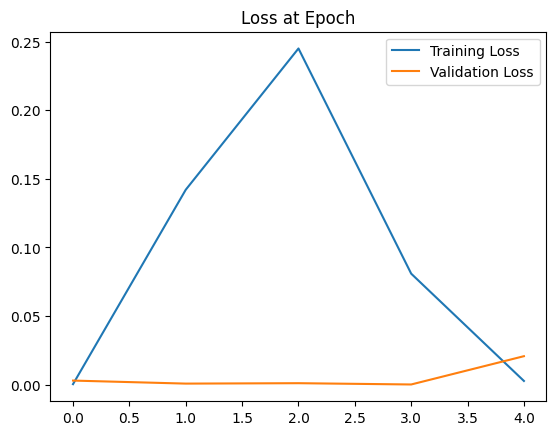

In [30]:
# Graph the loss at epoch

train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label = 'Training Loss')
plt.plot(test_losses, label = 'Validation Loss')
plt.title('Loss at Epoch')
plt.legend()

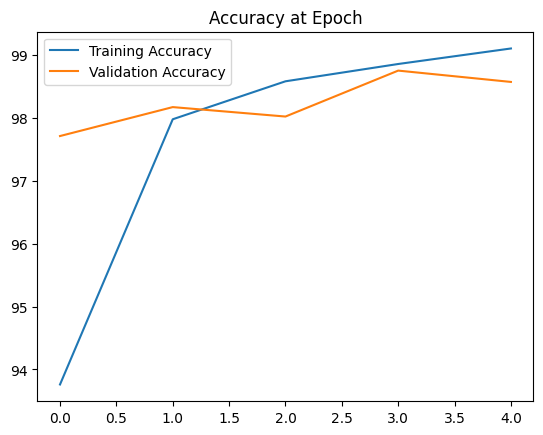

In [31]:
# Graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label = 'Training Accuracy')
plt.plot([t/100 for t in test_correct], label = 'Validation Accuracy')
plt.title('Accuracy at Epoch')
plt.legend()

In [32]:
test_load_everything = DataLoader(test_data, batch_size = 10000, shuffle = False)

In [33]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [34]:
# Did for correct
correct.item()/len(test_data)

0.9857

In [35]:
# Gra an image
test_data[1978] # Tensor with an image in it....at the end, it shows the label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [36]:
test_data[1978][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [37]:
# Reshape it
test_data[1978][0].reshape(28, 28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

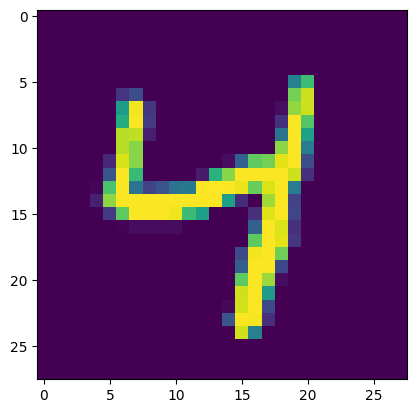

In [38]:
plt.imshow (test_data[1978][0].reshape(28, 28))

In [39]:
# pass the image thru our model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[1978][0].view(1, 1, 28, 28)) # batch size of 1, 1 color channel, 28x28 image


In [40]:
# Check the new prediction
new_prediction

tensor([[-2.4992e+01, -1.8860e+01, -2.4744e+01, -3.0158e+01, -4.7684e-07,
         -2.1318e+01, -2.2632e+01, -2.0485e+01, -2.1817e+01, -1.4484e+01]])

In [41]:
new_prediction.argmax()

tensor(4)

In [46]:
from PIL import Image
import requests
from io import BytesIO
from torchvision import transforms # Import transforms here

def analyze_image_from_url(image_url):
    # Define the transform inside the function
    transform = transforms.ToTensor()

    # Download the image
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))

    # Preprocess the image (convert to grayscale, resize, and normalize)
    img = img.convert('L')  # Convert to grayscale
    img = img.resize((28, 28))  # Resize to 28x28
    img_tensor = transform(img) # Use the same transform as for MNIST data
    img_tensor = img_tensor.view(1, 1, 28, 28) # Add batch and channel dimensions

    # Make a prediction
    model.eval()
    with torch.no_grad():
        prediction = model(img_tensor)

    # Display the image and prediction
    plt.imshow(img, cmap='gray')
    plt.title(f'Prediction: {prediction.argmax().item()}')
    plt.show()

# Example usage: Replace with your image URL
image_url = 'https://www.kidsmathgamesonline.com/images/pictures/numbers600/number1.jpg' # Replace with your image URL
analyze_image_from_url(image_url)

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x78f82bf3d5d0>

In [43]:
import torch

# Save the trained model's state dictionary
torch.save(model.state_dict(), 'mnist_cnn_model.pth')